# MLP - Top model according to the SCPM of -6.16

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Database Reading and Manipulation
import pandas as pd

# Linear Algebra
import numpy as np

# Time
import time

# Random and os for reproducibility
import random
import os

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_validate

# Modeling
import tensorflow as tf

# Processing
from sklearn.preprocessing import StandardScaler

# Pipeline
from sklearn.pipeline import Pipeline

# Data imputation
from sklearn.impute import SimpleImputer

# Making keras compatible with scikit learn api
# https://scikit-learn.org/stable/developers/develop.html
from sklearn.base import RegressorMixin

# Custom modules
## Model selection
from src.cross_validation.blocking_time_series_split import BlockingTimeSeriesSplit

## Function to print scores
from src.utils.print_scores import print_scores

## Function to calculate score regression metrics
from src.utils.score_regression_metrics import score_regression_metrics

## Function to fill the results metric dict
from src.utils.fill_results_dict import fill_results_dict

from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

2025-04-05 18:21:36.570426: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-05 18:21:36.572899: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-05 18:21:36.620917: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-05 18:21:36.622212: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-05 18:21:37.372390: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

<IPython.core.display.Javascript object>

# Functions and definitions

In [3]:
class MLP(RegressorMixin):
    def __init__(
        self,
        callbacks=None,
        validation_split=0.0,
    ):
        self.model = self.get_model()
        self.batch_size = 16
        self.epochs = 300
        self.verbose = 0
        self.callbacks = callbacks
        self.validation_split = validation_split

    def fit(self, X=None, y=None):
        self.model.build(X.shape)
        self.load_pretrained_weights()
        self.history = self.model.fit(
            X,
            y,
            batch_size=self.batch_size,
            epochs=self.epochs,
            verbose=self.verbose,
            callbacks=self.callbacks,
            validation_split=self.validation_split,
        )

    def predict(self, X=None):
        return self.model.predict(X, verbose=self.verbose)

    def get_model(self):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(units=256, activation="elu")),
        model.add(tf.keras.layers.Dense(units=128, activation="elu")),
        model.add(tf.keras.layers.Dropout(rate=0.25))
        model.add(tf.keras.layers.Dense(units=64, activation="elu")),
        model.add(tf.keras.layers.Dense(units=32, activation="elu")),
        model.add(tf.keras.layers.Dropout(rate=0.10))
        model.add(tf.keras.layers.Dense(units=16, activation="elu")),
        model.add(tf.keras.layers.Dense(units=1))
        model.compile(
            optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
            loss="mse",
            metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
        )
        return model

    def load_pretrained_weights(self, freeze_layers=0):
        # Load global weights
        self.model.load_weights(full_path)

        # Freeze layers
        for layer in self.model.layers[:freeze_layers]:
            layer.trainable = False
        if freeze_layers > 0:
            self.model.compile(
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
                loss="mse",
                metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
            )
        return

<IPython.core.display.Javascript object>

In [4]:
def set_seeds():
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
    os.environ["PYTHONHASHSEED"] = str(SEED)
    tf.random.set_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)


# https://stackoverflow.com/questions/36288235/how-to-get-stable-results-with-tensorflow-setting-random-seed

<IPython.core.display.Javascript object>

In [5]:
SEED = 47
METRICS = (
    "neg_root_mean_squared_error",
    "neg_mean_absolute_error",
    "neg_mean_absolute_percentage_error",
    "r2",
)
METRICS_DICT = {
    "neg_root_mean_squared_error": "RMSE",
    "neg_mean_absolute_error": "MAE",
    "neg_mean_absolute_percentage_error": "MAPE",
    "r2": "R2",
}

<IPython.core.display.Javascript object>

In [6]:
weights_path = "../../../../models/global_models/209/mlp/am/pre_training/"
model_name = "mlp_chemical_properties_csless_vars_weights.h5"
full_path = os.path.join(weights_path, model_name)

<IPython.core.display.Javascript object>

## Defining a dataframe structure to save the results

In [7]:
results_to_save = []

results_dict = {
    "Category": "Global Model",
    "Company": "209",
    "Plant": "AM",
    "Features": "Chemical + Properties CS Less",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "MLP",
    "Model Params": None,
    "Scaler": None,
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

# Reading the dataset

In [8]:
df = pd.read_csv("../../../../data/processed/209/am.csv")

<IPython.core.display.Javascript object>

## Defining Features

In this set of experiments we keep only chemical and mineralogical features yielded by the same testing method/procedure

In [9]:
df_copy = df.copy().drop(
    [
        "Cement_Type",
        "CS3",
        "CS7",
    ],
    axis=1,
)

<IPython.core.display.Javascript object>

# 1. Multi Layer Perceptron

<h2>1. Dataset: df_no_cs</h2> <br>In this dataset the CS1, CS3  and CS7 variables are not considered. Only Chemical and mineralogical features measured by the same method. For this particular dataset, all chemical features, with the exception of LOI were measured by XRF and XRD methods.

In [10]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

## 1.2. Blocking Time Series Cross Validation

<b>Dataset shape:</b> (1234, 38)<br>
<b>Splits:</b>5<br>    
    1. 5 folds of 246 samples
    2. 50% train (123 samples each fold)
    3. 50% test (123 samples each fold)
<b>Total:</b> 5 models<br>

In [11]:
set_seeds()
start = time.time()

repeats = 3
n_splits = 5
train_size = 0.8
scores_final = None
results_repeats = {}

for repeat in range(repeats):
    pipeline = Pipeline(
        [
            ("imputer", SimpleImputer(strategy="median")),
            ("transformer", StandardScaler()),
            ("estimator", MLP()),
        ]
    )
    cv = BlockingTimeSeriesSplit(n_splits=n_splits, train_size=train_size)
    scores = cross_validate(
        pipeline,
        x,
        y,
        scoring=METRICS,
        cv=cv,
        # n_jobs=None,
        return_train_score=True,
        return_estimator=True,
        return_indices=True,
    )
    results_repeats[repeat] = scores

    if scores_final is None:
        scores_final = {key: [] for key, _ in scores.items()}

    for key, value in scores.items():
        scores_final[key] += [value]


print("Blocking Time Series Split:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores_final, METRICS, METRICS_DICT)

scores = {key: np.array(val).flatten() for key, val in scores_final.items()}
results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Blocking Time Series Split"
results_dict_copy[
    "Cross Validation Params"
] = '{"N_Splits": 5, "Repeats": 3, "train_size": 0.8}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

end = time.time()
print("Minutes Elapsed: ", (end - start) / 60)

2025-04-05 18:21:39.559096: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-04-05 18:21:39.559169: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: inspirada
2025-04-05 18:21:39.559180: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: inspirada
2025-04-05 18:21:39.559404: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.183.1
2025-04-05 18:21:39.559440: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.183.1
2025-04-05 18:21:39.559450: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 535.183.1


Blocking Time Series Split:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -0.851 (0.039)
MAE: -0.636 (0.032)
MAPE: -0.015 (0.001)
R2: 0.980 (0.002)


******
[TEST]
******
RMSE: -0.978 (0.080)
MAE: -0.753 (0.056)
MAPE: -0.018 (0.001)
R2: 0.973 (0.003)


Minutes Elapsed:  10.088396759827932


<IPython.core.display.Javascript object>

## Plotting the Predictions

In [12]:
def get_predictions_df(scores):
    df_pred = pd.DataFrame()
    df_pred["DATE"] = dates.copy()
    df_pred["CS28"] = y.copy()
    df_pred["CS28_PRED"] = np.nan
    df_pred["SET"] = ""
    df_pred["CEMENT_TYPE"] = df["Cement_Type"].copy()
    df_pred["DATE"] = pd.to_datetime(df_pred["DATE"])

    for idx, pipeline in enumerate(scores["estimator"]):
        index_train = scores["indices"]["train"][idx]
        index_test = scores["indices"]["test"][idx]
        index_preds = np.concatenate([index_train, index_test])

        # results = scores["estimator"][0].predict(x.loc[index_preds])
        results = pipeline.predict(x.loc[index_preds])
        df_pred.loc[index_preds, "CS28_PRED"] = results.copy()
        df_pred.loc[index_train, "SET"] = "TRAIN"
        df_pred.loc[index_test, "SET"] = "TEST"
        df_pred.loc[index_train, "FOLD"] = idx + 1
        df_pred.loc[index_test, "FOLD"] = idx + 1
    df_pred = df_pred.dropna()
    return df_pred

<IPython.core.display.Javascript object>

In [13]:
dfs = []
for repeat in range(repeats):
    scores = results_repeats[repeat]
    df_pred = get_predictions_df(scores)
    df_pred["REPEAT"] = repeat
    dfs.append(df_pred)

df_pred = pd.concat(dfs)

<IPython.core.display.Javascript object>

In [14]:
df_pred = dfs[0]
df_pred["CS28_PRED"] = (
    dfs[0]["CS28_PRED"] + dfs[1]["CS28_PRED"] + dfs[2]["CS28_PRED"]
) / 3

<IPython.core.display.Javascript object>

In [15]:
df_copy_merge = (
    df_copy.reset_index(drop=True)
    .merge(
        df_pred.reset_index(drop=True), left_index=True, right_index=True, how="inner"
    )
    .drop("REPEAT", axis=1)
)

df_copy_merge["COMPANY"] = 209
df_copy_merge["PLANT"] = "AM"
df_copy_merge.to_excel("global_model_mlp_btsscv_209_am.xlsx", index=False)
df_copy_merge.to_csv("global_model_mlp_btsscv_209_am.csv", index=False)

<IPython.core.display.Javascript object>

In [16]:
df_pred.reset_index()

,index,DATE,CS28,CS28_PRED,SET,CEMENT_TYPE,FOLD,REPEAT
0,0,2021-01-04,39.600000,40.437893,TRAIN,CP IV-32,1.0,0
1,1,2021-01-04,44.700001,45.248287,TRAIN,CP II-F-40,1.0,0
2,2,2021-01-04,35.700001,35.101868,TRAIN,CP II-Z-32,1.0,0
3,3,2021-01-04,33.400002,34.275986,TRAIN,CP II-Z-32,1.0,0
4,4,2021-01-04,49.400002,47.117649,TRAIN,CP V-ARI,1.0,0
...,...,...,...,...,...,...,...,...
3770,3770,2023-07-22,39.200001,40.903275,TEST,CP IV-32,5.0,0
3771,3771,2023-07-22,48.000000,48.379280,TEST,CP V-ARI,5.0,0
3772,3772,2023-07-24,47.000000,48.481613,TEST,CP V-ARI,5.0,0
3773,3773,2023-07-25,47.000000,48.242226,TEST,CP V-ARI,5.0,0


<IPython.core.display.Javascript object>

In [17]:
df_copy_merge

,Date,CaO,MgO,Na2O,Al2O3,SiO2,SO3,K2O,Fe2O3,Loss on Ignition,...,Initial setting time,Final setting time,DATE,CS28,CS28_PRED,SET,CEMENT_TYPE,FOLD,COMPANY,PLANT
0,2021-01-04,44.580000,5.00000,0.19000,9.11000,30.570000,NaN,1.40000,3.85000,3.69,...,335.0,410.0,2021-01-04,39.600000,40.437893,TRAIN,CP IV-32,1.0,209,AM
1,2021-01-04,59.930000,6.45000,0.04000,4.47000,17.920000,2.36000,0.89000,2.82000,5.14,...,260.0,330.0,2021-01-04,44.700001,45.248287,TRAIN,CP II-F-40,1.0,209,AM
2,2021-01-04,53.959999,5.89000,0.12000,6.05000,22.430000,2.43000,0.99000,3.05000,5.99,...,305.0,380.0,2021-01-04,35.700001,35.101868,TRAIN,CP II-Z-32,1.0,209,AM
3,2021-01-04,53.070000,5.62000,0.08000,5.91000,23.070000,2.39000,1.12000,3.19000,7.43,...,290.0,365.0,2021-01-04,33.400002,34.275986,TRAIN,CP II-Z-32,1.0,209,AM
4,2021-01-04,59.349998,6.31000,0.06000,4.43000,18.780001,3.10000,0.89000,2.90000,3.06,...,240.0,310.0,2021-01-04,49.400002,47.117649,TRAIN,CP V-ARI,1.0,209,AM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3770,2023-07-22,41.809059,4.91223,0.34176,8.80051,29.123569,2.07947,1.34512,3.82240,3.90,...,250.0,310.0,2023-07-22,39.200001,40.903275,TEST,CP IV-32,5.0,209,AM
3771,2023-07-22,56.844349,5.60756,0.22795,4.23547,17.110439,3.34224,0.82983,2.63504,3.71,...,240.0,300.0,2023-07-22,48.000000,48.379280,TEST,CP V-ARI,5.0,209,AM
3772,2023-07-24,58.476791,6.71464,0.22987,4.39698,17.998449,3.39121,0.85207,2.68371,3.64,...,250.0,310.0,2023-07-24,47.000000,48.481613,TEST,CP V-ARI,5.0,209,AM
3773,2023-07-25,58.936352,7.80908,0.21943,4.48254,18.767210,2.94541,0.83483,2.77901,3.29,...,240.0,295.0,2023-07-25,47.000000,48.242226,TEST,CP V-ARI,5.0,209,AM


<IPython.core.display.Javascript object>

In [18]:
# df_copy_merge
df_copy_merge

,Date,CaO,MgO,Na2O,Al2O3,SiO2,SO3,K2O,Fe2O3,Loss on Ignition,...,Initial setting time,Final setting time,DATE,CS28,CS28_PRED,SET,CEMENT_TYPE,FOLD,COMPANY,PLANT
0,2021-01-04,44.580000,5.00000,0.19000,9.11000,30.570000,NaN,1.40000,3.85000,3.69,...,335.0,410.0,2021-01-04,39.600000,40.437893,TRAIN,CP IV-32,1.0,209,AM
1,2021-01-04,59.930000,6.45000,0.04000,4.47000,17.920000,2.36000,0.89000,2.82000,5.14,...,260.0,330.0,2021-01-04,44.700001,45.248287,TRAIN,CP II-F-40,1.0,209,AM
2,2021-01-04,53.959999,5.89000,0.12000,6.05000,22.430000,2.43000,0.99000,3.05000,5.99,...,305.0,380.0,2021-01-04,35.700001,35.101868,TRAIN,CP II-Z-32,1.0,209,AM
3,2021-01-04,53.070000,5.62000,0.08000,5.91000,23.070000,2.39000,1.12000,3.19000,7.43,...,290.0,365.0,2021-01-04,33.400002,34.275986,TRAIN,CP II-Z-32,1.0,209,AM
4,2021-01-04,59.349998,6.31000,0.06000,4.43000,18.780001,3.10000,0.89000,2.90000,3.06,...,240.0,310.0,2021-01-04,49.400002,47.117649,TRAIN,CP V-ARI,1.0,209,AM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3770,2023-07-22,41.809059,4.91223,0.34176,8.80051,29.123569,2.07947,1.34512,3.82240,3.90,...,250.0,310.0,2023-07-22,39.200001,40.903275,TEST,CP IV-32,5.0,209,AM
3771,2023-07-22,56.844349,5.60756,0.22795,4.23547,17.110439,3.34224,0.82983,2.63504,3.71,...,240.0,300.0,2023-07-22,48.000000,48.379280,TEST,CP V-ARI,5.0,209,AM
3772,2023-07-24,58.476791,6.71464,0.22987,4.39698,17.998449,3.39121,0.85207,2.68371,3.64,...,250.0,310.0,2023-07-24,47.000000,48.481613,TEST,CP V-ARI,5.0,209,AM
3773,2023-07-25,58.936352,7.80908,0.21943,4.48254,18.767210,2.94541,0.83483,2.77901,3.29,...,240.0,295.0,2023-07-25,47.000000,48.242226,TEST,CP V-ARI,5.0,209,AM


<IPython.core.display.Javascript object>

In [19]:
df_pred[["DATE", "CS28", "CS28_PRED", "SET"]]

,DATE,CS28,CS28_PRED,SET
0,2021-01-04,39.600000,40.437893,TRAIN
1,2021-01-04,44.700001,45.248287,TRAIN
2,2021-01-04,35.700001,35.101868,TRAIN
3,2021-01-04,33.400002,34.275986,TRAIN
4,2021-01-04,49.400002,47.117649,TRAIN
...,...,...,...,...
3770,2023-07-22,39.200001,40.903275,TEST
3771,2023-07-22,48.000000,48.379280,TEST
3772,2023-07-24,47.000000,48.481613,TEST
3773,2023-07-25,47.000000,48.242226,TEST


<IPython.core.display.Javascript object>

In [20]:
df_pred

,DATE,CS28,CS28_PRED,SET,CEMENT_TYPE,FOLD,REPEAT
0,2021-01-04,39.600000,40.437893,TRAIN,CP IV-32,1.0,0
1,2021-01-04,44.700001,45.248287,TRAIN,CP II-F-40,1.0,0
2,2021-01-04,35.700001,35.101868,TRAIN,CP II-Z-32,1.0,0
3,2021-01-04,33.400002,34.275986,TRAIN,CP II-Z-32,1.0,0
4,2021-01-04,49.400002,47.117649,TRAIN,CP V-ARI,1.0,0
...,...,...,...,...,...,...,...
3770,2023-07-22,39.200001,40.903275,TEST,CP IV-32,5.0,0
3771,2023-07-22,48.000000,48.379280,TEST,CP V-ARI,5.0,0
3772,2023-07-24,47.000000,48.481613,TEST,CP V-ARI,5.0,0
3773,2023-07-25,47.000000,48.242226,TEST,CP V-ARI,5.0,0


<IPython.core.display.Javascript object>

In [21]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc_file_defaults()

<IPython.core.display.Javascript object>

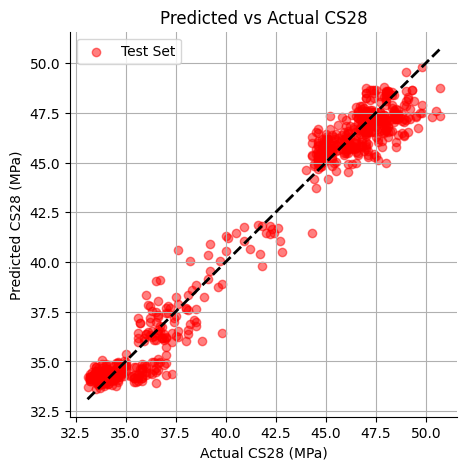

<IPython.core.display.Javascript object>

In [22]:
# Filter to only include the test set
test_data = df_pred[df_pred["SET"] == "TEST"]

# Plot Predicted vs Actual for the test set
plt.figure(figsize=(5.0, 5.0))
plt.scatter(
    test_data["CS28"], test_data["CS28_PRED"], color="red", alpha=0.5, label="Test Set"
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    "k--",
    lw=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig("ecics_global_cm_p_btiss_fine_tuning_dominant_top_one_pred_vs_actual_cs28.png", dpi=300, bbox_inches='tight')

plt.show()
# USAR ESSE



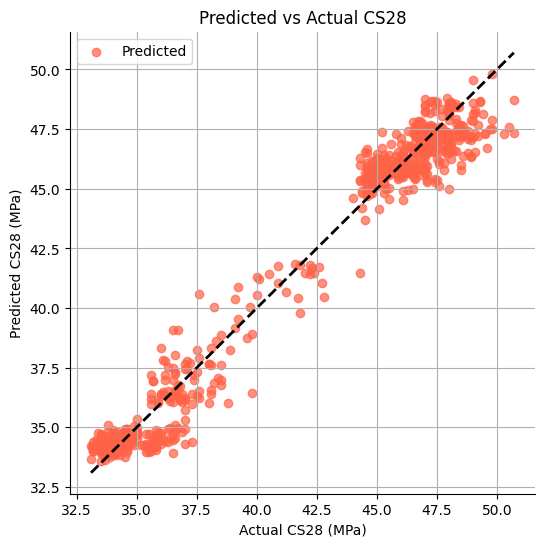

<IPython.core.display.Javascript object>

In [23]:
plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"], test_data["CS28_PRED"], color="tomato", alpha=0.7, label="Predicted"
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black", linestyle="--", linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig("ecics_global_cm_p_btiss_fine_tuning_dominant_top_one_pred_vs_actual_cs28.png", dpi=300, bbox_inches='tight')
plt.show()


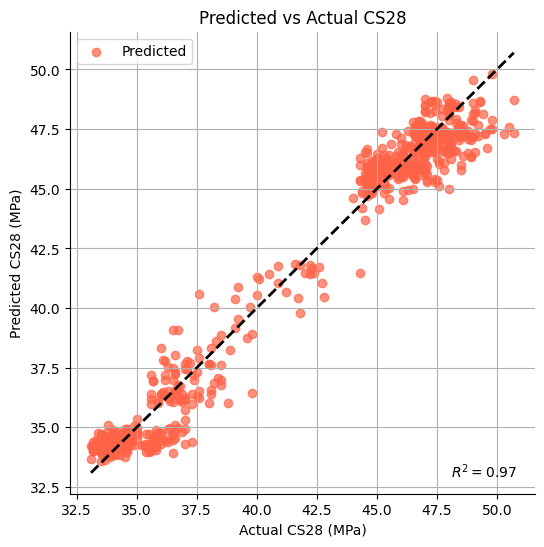

<IPython.core.display.Javascript object>

In [24]:
plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"], test_data["CS28_PRED"], color="tomato", alpha=0.7, label="Predicted"
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black", linestyle="--", linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

r2 = 0.97
plt.text(
    0.82,
    0.07,
    f"$R^2 = {r2:.2f}$",
    transform=plt.gca().transAxes,
    verticalalignment="top",
)

plt.savefig("ecics_global_cm_p_btiss_fine_tuning_dominant_top_one_pred_vs_actual_cs28.png", dpi=300, bbox_inches='tight')
plt.show()


In [25]:
df["Cement_Type"].value_counts()

Cement_Type
CP II-Z-32    1179
CP II-F-40     941
CP V-ARI       811
CP II-F-32     355
CP II-Z-40     306
CP IV-32       184
Name: count, dtype: int64

<IPython.core.display.Javascript object>

In [26]:
df[df["Cement_Type"].eq("CP V-ARI")]["CS28"].describe()

count    811.000000
mean      47.572133
std        1.480270
min       44.000000
25%       47.000000
50%       47.500000
75%       48.350000
max       53.799999
Name: CS28, dtype: float64

<IPython.core.display.Javascript object>

In [27]:
test_data[
    (test_data["CS28"] > 34)
    & (test_data["CS28"] < 36)
    & (test_data["CS28_PRED"] > 42)
    & (test_data["CS28_PRED"] < 44)
]

,DATE,CS28,CS28_PRED,SET,CEMENT_TYPE,FOLD,REPEAT


<IPython.core.display.Javascript object>

In [28]:
df_pred["CS28"][(df_pred["CS28"] < 38) & (df_pred["SET"] == "TRAIN")].describe()

count    1237.000000
mean       34.773888
std         1.237810
min        33.000000
25%        33.799999
50%        34.400002
75%        35.799999
max        37.900000
Name: CS28, dtype: float64

<IPython.core.display.Javascript object>

In [29]:
df_pred["CS28"][(df_pred["CS28"] > 44) & (df_pred["SET"] == "TRAIN")].describe()

count    1637.000000
mean       46.851662
std         1.520308
min        44.099998
25%        45.599998
50%        47.000000
75%        47.700001
max        53.799999
Name: CS28, dtype: float64

<IPython.core.display.Javascript object>

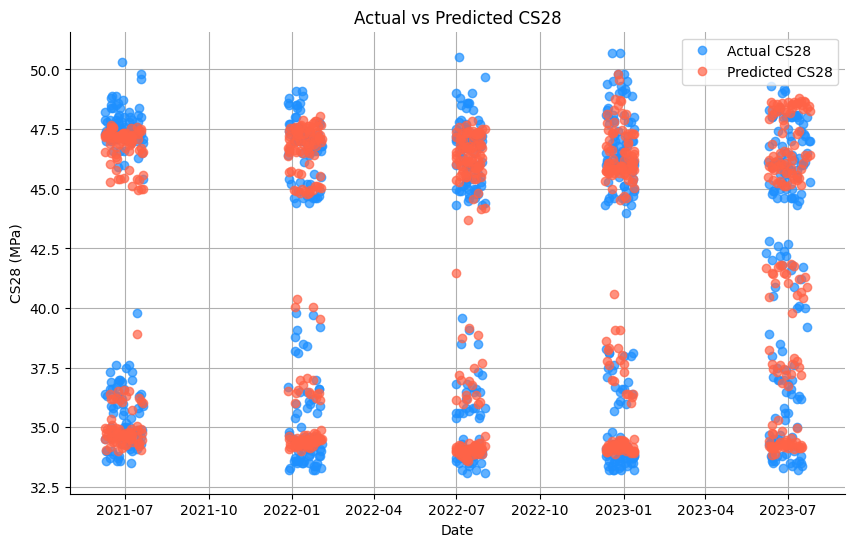

<IPython.core.display.Javascript object>

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(
    test_data["DATE"],
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Actual CS28",
)
plt.plot(
    test_data["DATE"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
)
plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
plt.title("Actual vs Predicted CS28")
plt.legend(loc="best")
plt.grid(True)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "ecics_global_cm_p_btiss_fine_tuning_dominant_top_one_pred_vs_actual_cs28_over_time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


/tmp/ipykernel_154755/3330986098.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["RESIDUAL"] = test_data["CS28"] - test_data["CS28_PRED"]


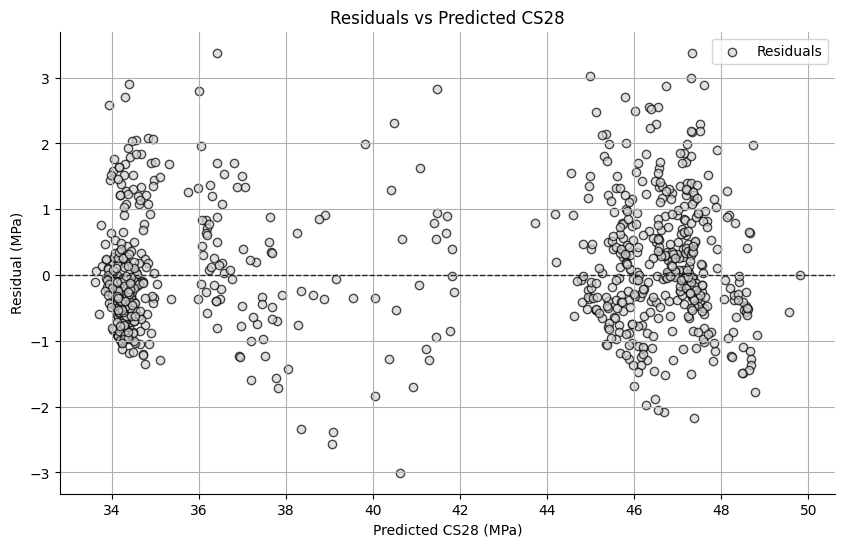

<IPython.core.display.Javascript object>

In [31]:
test_data["RESIDUAL"] = test_data["CS28"] - test_data["CS28_PRED"]

plt.figure(figsize=(10, 6))

# Plot residuals vs predicted values
plt.scatter(
    test_data["CS28_PRED"],
    test_data["RESIDUAL"],
    color="lightgray",
    alpha=0.7,
    edgecolor="black",
    label="Residuals"
)

# Add horizontal line at zero for reference
plt.axhline(y=0, color="black", linestyle="--", linewidth=1, alpha=0.8)

plt.xlabel("Predicted CS28 (MPa)")
plt.ylabel("Residual (MPa)")
plt.title("Residuals vs Predicted CS28")
plt.legend()
plt.grid(True)

# Remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Save the figure
plt.savefig(
    "ecics_global_cm_p_btiss_top_one_fine_tuning_residuals_vs_predicted.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


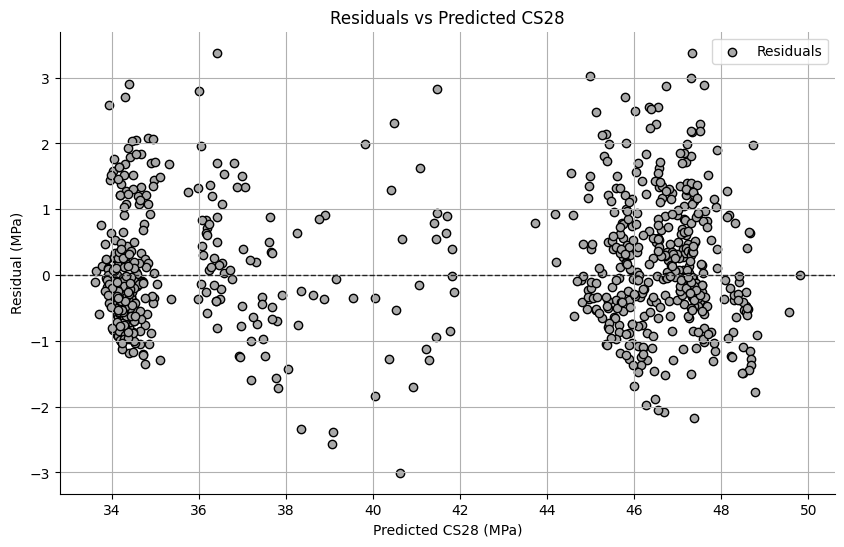

<IPython.core.display.Javascript object>

In [32]:
plt.figure(figsize=(10, 6))

# Plot residuals vs predicted values
plt.scatter(
    test_data["CS28_PRED"],
    test_data["RESIDUAL"],
    color="darkgray",
    alpha=1,
    edgecolor="black",
    label="Residuals",
)

# Add horizontal line at zero for reference
plt.axhline(y=0, color="black", linestyle="--", linewidth=1, alpha=0.8)

plt.xlabel("Predicted CS28 (MPa)")
plt.ylabel("Residual (MPa)")
plt.title("Residuals vs Predicted CS28")
plt.legend()
plt.grid(True)

# Remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Save the figure
# plt.savefig(
#     "ecics_global_cm_p_btiss_top_one_fine_tuning_residuals_vs_predicted.png",
#     dpi=300,
#     bbox_inches="tight",
# )

plt.show()

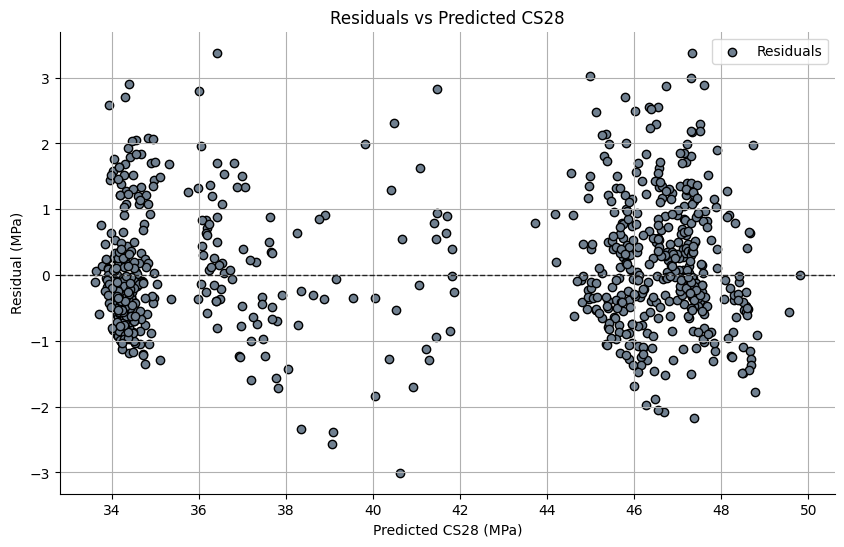

<IPython.core.display.Javascript object>

In [33]:
plt.figure(figsize=(10, 6))

# Plot residuals vs predicted values
plt.scatter(
    test_data["CS28_PRED"],
    test_data["RESIDUAL"],
    color="slategray",
    alpha=1,
    edgecolor="black",
    label="Residuals",
)

# Add horizontal line at zero for reference
plt.axhline(y=0, color="black", linestyle="--", linewidth=1, alpha=0.8)

plt.xlabel("Predicted CS28 (MPa)")
plt.ylabel("Residual (MPa)")
plt.title("Residuals vs Predicted CS28")
plt.legend()
plt.grid(True)

# Remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Save the figure
# plt.savefig(
#     "ecics_global_cm_p_btiss_top_one_fine_tuning_residuals_vs_predicted.png",
#     dpi=300,
#     bbox_inches="tight",
# )

plt.show()

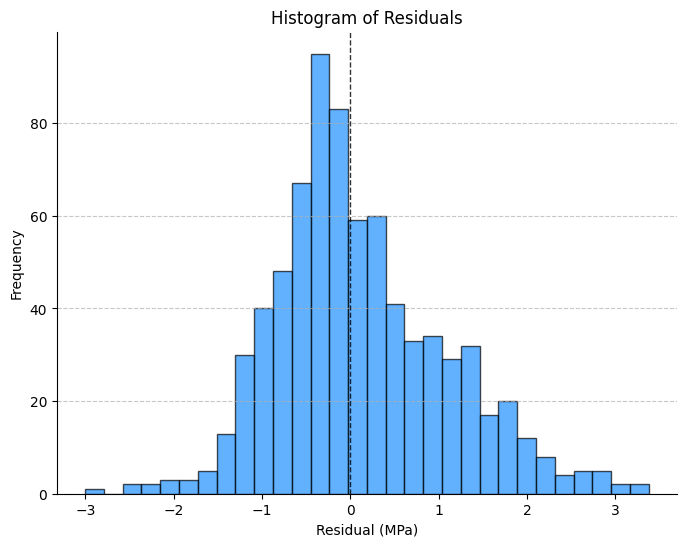

<IPython.core.display.Javascript object>

In [34]:
plt.figure(figsize=(8, 6))

# Plot histogram of residuals
plt.hist(
    test_data["RESIDUAL"],
    bins=30,  # Number of bins for better granularity
    color="dodgerblue",
    edgecolor="black",
    alpha=0.7
)

# Add labels and title
plt.xlabel("Residual (MPa)")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")

# Add a vertical line at 0 for reference
plt.axvline(x=0, color="black", linestyle="--", linewidth=1, alpha=0.8)

# Grid for readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Remove top and right spines for cleaner aesthetics
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Save the plot
plt.savefig(
    "ecics_global_cm_p_btiss_dominant_top_one_fine_tuning_residual_histogram.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()


## Assessing Feature Importance

In [35]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tqdm import tqdm

<IPython.core.display.Javascript object>

In [36]:
perm_importances = []

for repeat in range(repeats):
    scores = results_repeats[repeat]
    estimators = scores["estimator"]
    indices = scores["indices"]
    test_index = indices["test"]
    estimators = scores["estimator"]
    indices = scores["indices"]
    test_indexes = indices["test"]

    for i, (pipeline, test_idx) in tqdm(enumerate(zip(estimators, test_indexes))):
        result = permutation_importance(
            pipeline,
            x.iloc[test_idx],
            y[test_idx],
            n_repeats=10,
            random_state=SEED,
            n_jobs=1,
            scoring="r2",
        )
        perm_importances.append(result.importances_mean)

5it [00:40,  8.07s/it]
5it [00:39,  7.94s/it]
5it [00:40,  8.10s/it]


<IPython.core.display.Javascript object>

In [37]:
# Average importances across folds
mean_importances = np.mean(perm_importances, axis=0)

# importances_df = pd.DataFrame(feature_importances, columns=x.columns)
# Transpose the list of arrays so that each row corresponds to a permutation/model, and each column to a feature
importances_df = pd.DataFrame(perm_importances)

# Assign the feature names to the columns
importances_df.columns = x.columns

# Map importances to feature names
importances_df_mean = (
    importances_df.mean(axis=0)
    .to_frame()
    .reset_index(0)
    .rename({"index": "Feature", 0: "Importance"}, axis=1)
)

<IPython.core.display.Javascript object>

In [38]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

<IPython.core.display.Javascript object>

In [39]:
rename_dict = {
    "K2O": r"$\mathrm{K_2O}$",
    "Free CaO": r"Free $\mathrm{CaO}$",
    "Total C2S": r"Total $\mathrm{C_2S}$",
    "Na2O": r"$\mathrm{Na_2O}$",
    "CaO": r"$\mathrm{CaO}$",
    "SiO2": r"$\mathrm{SiO_2}$",
    "MgO": r"$\mathrm{MgO}$",
    "Fe2O3": r"$\mathrm{Fe_2O_3}$",
    "Al2O3": r"$\mathrm{Al_2O_3}$",
    "Total C3S": r"Total $\mathrm{C_3S}$",
    "C3A": r"$\mathrm{C_3A}$",
    "C4AF": r"$\mathrm{C_4AF}$",
    "LOI": "LOI",
    "SO3": r"$\mathrm{SO_3}$",
    "Insoluble Residue": "IR",
    "Loss on Ignition": "LOI",
}

importances_df = importances_df.rename(rename_dict, axis=1)
importances_df_mean["Feature"] = importances_df_mean["Feature"].replace(rename_dict)

<IPython.core.display.Javascript object>

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


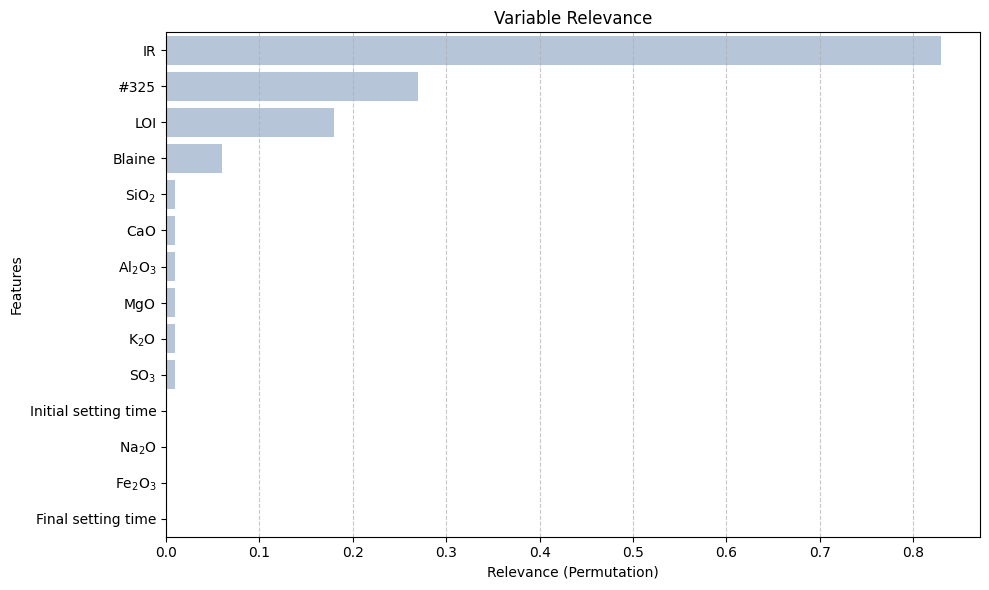

<IPython.core.display.Javascript object>

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort importances
mean_importances_df = importances_df_mean.sort_values(by='Importance', ascending=False).round(2)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=mean_importances_df, color="lightsteelblue")
plt.title("Variable Relevance")
plt.xlabel("Relevance (Permutation)")
plt.ylabel("Features")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
# plt.savefig(
#     "variable_relevance.png",
#     dpi=300,
#     bbox_inches="tight",
# )
plt.show()


/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_d

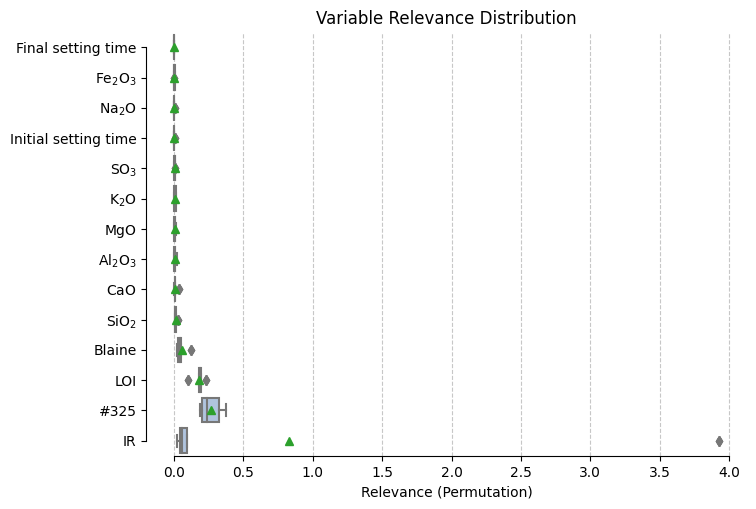

<IPython.core.display.Javascript object>

In [41]:
perm_importances_df = importances_df


# Calculate the mean importance for each feature
mean_importances = perm_importances_df.mean().sort_values()

# Reorder the DataFrame columns based on mean importance
perm_importances_df = perm_importances_df[mean_importances.index]


# Backup the original backend
original_backend = plt.get_backend()

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)

# Convert chemical formulas using MathText syntax
perm_importances_df_plot = perm_importances_df.rename(
    columns={
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
        "Loss on Ignition": "LOI",
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (Permutation)")
plt.title("Variable Relevance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_global_cm_p_tiss_fine_tuning_mlp_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

plt.show()

In [42]:
df_importances = perm_importances_df

<IPython.core.display.Javascript object>

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_d

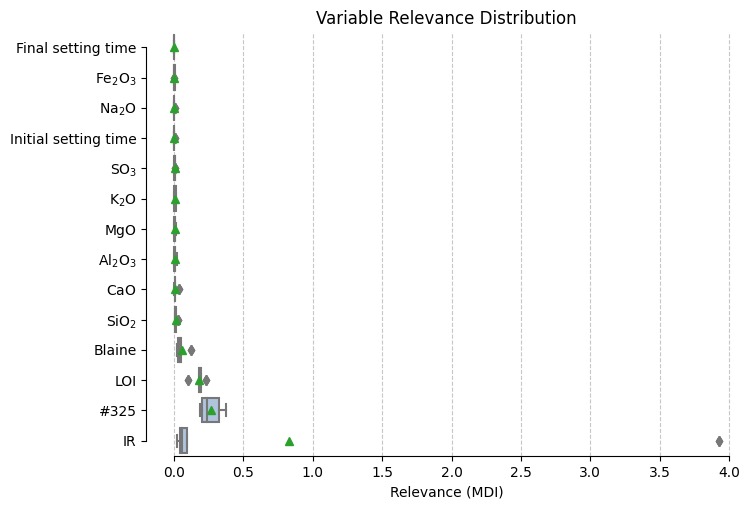

<IPython.core.display.Javascript object>

In [43]:
# Calculate the means of the importance scores
mean_importances = df_importances.mean()

# Sort the features by their mean relevance
sorted_features = mean_importances.sort_values()

# Re-order the DataFrame according to the sorted features
df_importances_sorted = df_importances[sorted_features.index]

# Plot the sorted boxplot
df_importances_sorted = df_importances_sorted.rename(
    columns={"Loss on Ignition": "LOI"}
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=df_importances_sorted,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (MDI)")
plt.title("Variable Relevance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig("ecics_global_cm_p_tiss_fine_tuning_mlp_scpm_best_dist_var_perm_relevance.png", dpi=300, bbox_inches='tight')
plt.show()


/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_d

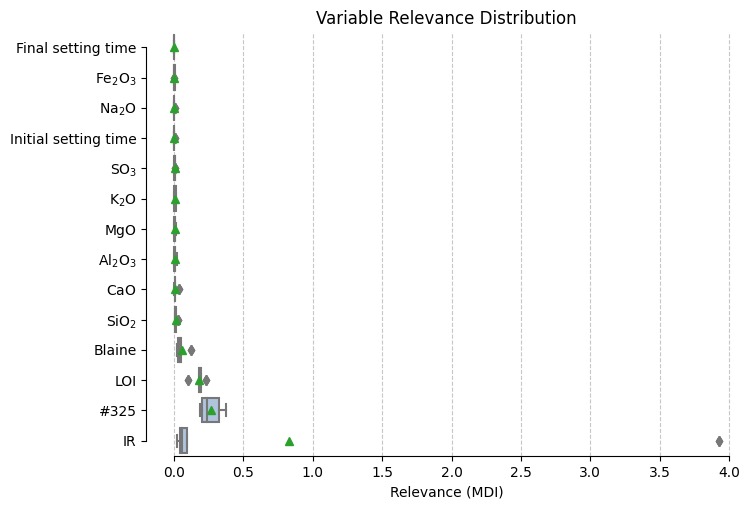

<IPython.core.display.Javascript object>

In [44]:
# Backup the original backend
original_backend = plt.get_backend()

# Use Matplotlib's default backend
# plt.switch_backend("agg")  # or any backend you prefer

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)


# Convert chemical formulas using MathText syntax
df_importances_sorted_plot = df_importances_sorted.rename(
    columns={
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=df_importances_sorted_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (MDI)")
plt.title("Variable Relevance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_global_cm_p_tiss_fine_tuning_mlp_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

In [45]:
df_importances

,Final setting time,$\mathrm{Fe_2O_3}$,$\mathrm{Na_2O}$,Initial setting time,$\mathrm{SO_3}$,$\mathrm{K_2O}$,$\mathrm{MgO}$,$\mathrm{Al_2O_3}$,$\mathrm{CaO}$,$\mathrm{SiO_2}$,Blaine,LOI,#325,IR
0,0.001799,0.007048,0.002235,0.004297,0.009282,0.004355,0.004377,0.008517,0.001234,0.004992,0.125902,0.193504,0.203492,0.021355
1,-0.000006,0.002734,0.000237,0.004119,0.004303,0.013592,0.016940,0.002112,0.007279,0.010447,0.048805,0.186539,0.326050,0.056913
2,0.001859,-0.000906,0.003636,0.001711,0.004389,0.006078,0.007481,0.001309,0.008534,0.010836,0.043979,0.232874,0.185652,0.042829
3,0.001099,0.003530,0.003314,0.011615,0.005229,0.000493,0.009848,0.019450,0.036378,0.015277,0.025784,0.178617,0.239359,0.091124
4,0.002226,0.004920,0.011037,0.000800,0.004944,0.015115,0.001310,0.011341,0.004845,0.029966,0.031972,0.103887,0.373665,3.928056
5,0.001799,0.007048,0.002235,0.004297,0.009282,0.004355,0.004377,0.008517,0.001234,0.004992,0.125902,0.193504,0.203492,0.021355
6,-0.000006,0.002734,0.000237,0.004119,0.004303,0.013592,0.016940,0.002112,0.007279,0.010447,0.048805,0.186539,0.326050,0.056913
7,0.001859,-0.000906,0.003636,0.001711,0.004389,0.006078,0.007481,0.001309,0.008534,0.010836,0.043979,0.232874,0.185652,0.042829
8,0.001099,0.003530,0.003314,0.011615,0.005229,0.000493,0.009848,0.019450,0.036378,0.015277,0.025784,0.178617,0.239359,0.091124
9,0.002226,0.004920,0.011037,0.000800,0.004944,0.015115,0.001310,0.011341,0.004845,0.029966,0.031972,0.103887,0.373665,3.928056


<IPython.core.display.Javascript object>

In [46]:
df_importances.describe().T

,count,mean,std,min,25%,50%,75%,max
Final setting time,15.0,0.001395,0.000818,-0.000006,0.001099,0.001799,0.001859,0.002226
$\mathrm{Fe_2O_3}$,15.0,0.003465,0.002723,-0.000906,0.002734,0.003530,0.004920,0.007048
$\mathrm{Na_2O}$,15.0,0.004092,0.003799,0.000237,0.002235,0.003314,0.003636,0.011037
Initial setting time,15.0,0.004508,0.003935,0.000800,0.001711,0.004119,0.004297,0.011615
$\mathrm{SO_3}$,15.0,0.005629,0.001924,0.004303,0.004389,0.004944,0.005229,0.009282
$\mathrm{K_2O}$,15.0,0.007927,0.005767,0.000493,0.004355,0.006078,0.013592,0.015115
$\mathrm{MgO}$,15.0,0.007991,0.005506,0.001310,0.004377,0.007481,0.009848,0.016940
$\mathrm{Al_2O_3}$,15.0,0.008546,0.006874,0.001309,0.002112,0.008517,0.011341,0.019450
$\mathrm{CaO}$,15.0,0.011654,0.013053,0.001234,0.004845,0.007279,0.008534,0.036378
$\mathrm{SiO_2}$,15.0,0.014304,0.008782,0.004992,0.010447,0.010836,0.015277,0.029966


<IPython.core.display.Javascript object>

# Analysis of predictions on the Global Dataset

*The model is the same. However We'll show the predictions of it on the global dataset*

## Reading the dataset

In [47]:
df = pd.read_csv("../../../../data/processed/209/global_am.csv")

<IPython.core.display.Javascript object>

## Defining the features

In [48]:
df_copy = df.copy().drop(
    [
        "Factory_Plant",
        "Cement_Type",
        # "CS1",
        "CS3",
        "CS7",
    ],
    axis=1,
)

<IPython.core.display.Javascript object>

In [49]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

In [50]:
class MLP(RegressorMixin):
    def __init__(
        self,
        callbacks=None,
        validation_split=0.0,
    ):
        self.model = self.get_model()
        self.batch_size = 16
        self.epochs = 300
        self.verbose = 0
        self.callbacks = callbacks
        self.validation_split = validation_split
        self.num_features = x.shape[-1]
        dummy_input_shape = (
            self.batch_size,
            self.num_features,
        )
        self.model.build(dummy_input_shape)

    def fit(self, X=None, y=None):
        self.model.build(X.shape)
        self.load_pretrained_weights()
        self.history = self.model.fit(
            X,
            y,
            batch_size=self.batch_size,
            epochs=self.epochs,
            verbose=self.verbose,
            callbacks=self.callbacks,
            validation_split=self.validation_split,
        )

    def predict(self, X=None):
        return self.model.predict(X, verbose=self.verbose)

    def get_model(self):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(units=256, activation="elu")),
        model.add(tf.keras.layers.Dense(units=128, activation="elu")),
        model.add(tf.keras.layers.Dropout(rate=0.25))
        model.add(tf.keras.layers.Dense(units=64, activation="elu")),
        model.add(tf.keras.layers.Dense(units=32, activation="elu")),
        model.add(tf.keras.layers.Dropout(rate=0.10))
        model.add(tf.keras.layers.Dense(units=16, activation="elu")),
        model.add(tf.keras.layers.Dense(units=1))
        model.compile(
            optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
            loss="mse",
            metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
        )
        return model

    def load_pretrained_weights(self, freeze_layers=0):
        # Load global weights
        self.model.load_weights(full_path)

        # Freeze layers
        for layer in self.model.layers[:freeze_layers]:
            layer.trainable = False
        if freeze_layers > 0:
            self.model.compile(
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
                loss="mse",
                metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
            )
        return

<IPython.core.display.Javascript object>

In [51]:
SimpleImputer

sklearn.impute._base.SimpleImputer

<IPython.core.display.Javascript object>

In [52]:
weights_path = "../../../../models/global_models/209/mlp/am/pre_training/"
model_name = "mlp_chemical_properties_csless_vars_partial_ds_weights.h5"

full_path = os.path.join(weights_path, model_name)

# Split train test sets
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=SEED, shuffle=False
)

test_index = x_test.index
dates_test = df[["Date"]].iloc[test_index]

imputer = SimpleImputer(strategy="median")
transformer = StandardScaler()

x_train = transformer.fit_transform(imputer.fit_transform(x_train))
x_test = transformer.transform(imputer.transform(x_test))

model = MLP()
model.load_pretrained_weights()

# Make predictions
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)
scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)

print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 1.914 (0.000)
MAE: 1.445 (0.000)
MAPE: 0.032 (0.000)
R2: 0.922 (0.000)


******
[TEST]
******
RMSE: 2.175 (0.000)
MAE: 1.596 (0.000)
MAPE: 0.038 (0.000)
R2: 0.868 (0.000)




<IPython.core.display.Javascript object>

In [53]:
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

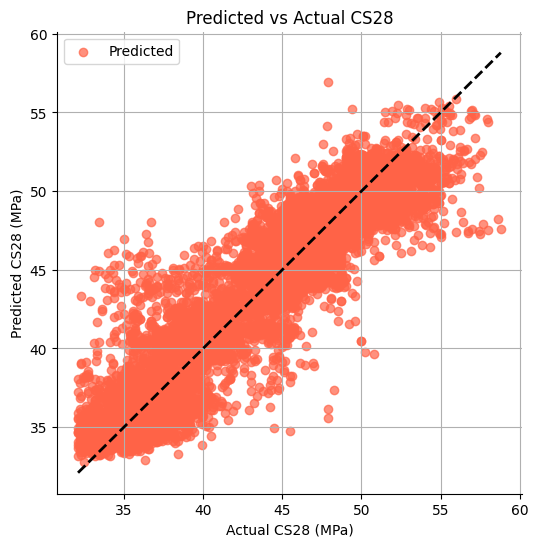

<IPython.core.display.Javascript object>

In [54]:
test_data = pd.DataFrame(
    {
        "DATE": dates_test.values.squeeze(),
        "CS28": y_test,
        "CS28_PRED": y_test_pred.squeeze(),
    }
)
test_data = test_data[test_data["CS28"] > 32]

plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    label="Predicted",
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black",
    linestyle="--",
    linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "ecics_global_cm_p_btiss_pre_train_dominant_top_one_pred_vs_actual_cs28.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

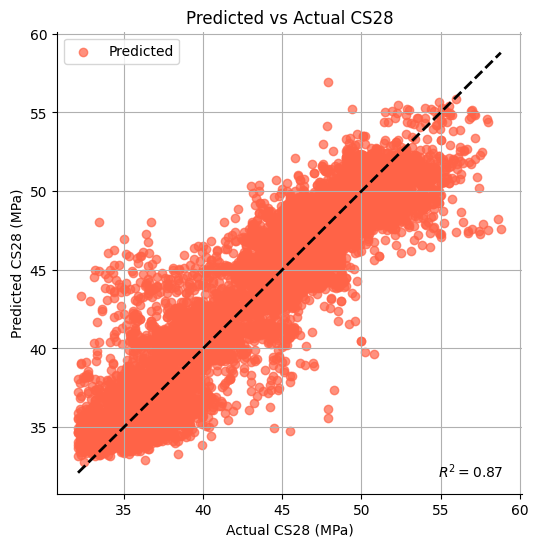

<IPython.core.display.Javascript object>

In [55]:
test_data = pd.DataFrame(
    {
        "DATE": dates_test.values.squeeze(),
        "CS28": y_test,
        "CS28_PRED": y_test_pred.squeeze(),
    }
)
test_data = test_data[test_data["CS28"] > 32]

plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    label="Predicted",
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black",
    linestyle="--",
    linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

r2 = 0.87
plt.text(
    0.82,
    0.07,
    f"$R^2 = {r2:.2f}$",
    transform=plt.gca().transAxes,
    verticalalignment="top",
)

plt.savefig(
    "ecics_global_cm_p_btiss_pre_train_dominant_top_one_pred_vs_actual_cs28.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

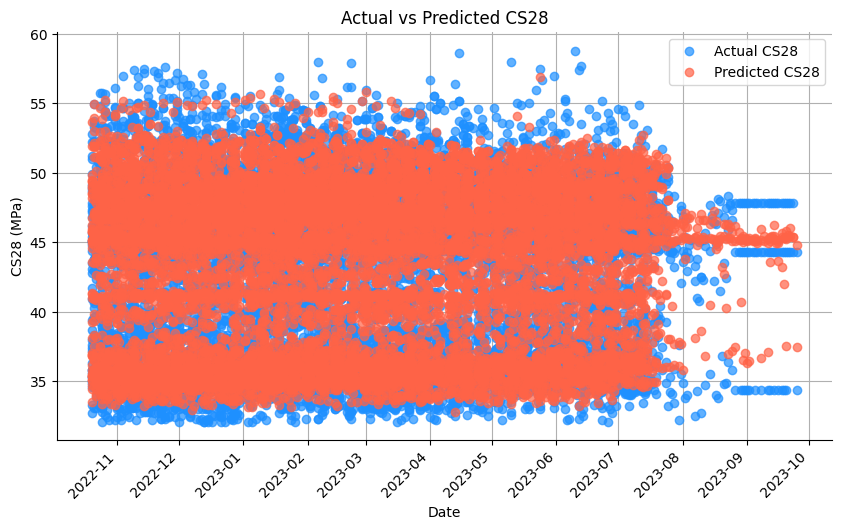

<IPython.core.display.Javascript object>

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert dates to datetime if they aren't already
test_data = pd.DataFrame(
    {
        "DATE": pd.to_datetime(dates_test["Date"]),
        "CS28": y_test,
        "CS28_PRED": y_test_pred.squeeze(),
    }
)

test_data = test_data[test_data["CS28"] > 32]


plt.figure(figsize=(10, 6))

# Add vertical line exactly at the start of test data first (so it's behind the points)
# test_start_date = test_data["DATE"].iloc[0]  # Get the exact first date of test data
# plt.axvline(x=test_start_date, color="gray", linestyle="--", alpha=0.5)


# Plot actual test data
plt.plot(
    test_data["DATE"],
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Actual CS28",
    markersize=6,
)

# Plot test predictions
plt.plot(
    test_data["DATE"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
    markersize=6,
)

plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
# plt.title("Actual CS28 (Full Series) vs Predicted CS28 (Test Period)")
plt.title("Actual vs Predicted CS28")

plt.legend()
plt.grid(True)

# Improving x-axis readability with 2-month intervals
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.gcf().autofmt_xdate(rotation=45)

# Remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Save the figure
plt.savefig(
    "ecics_global_cm_p_btiss_pre_train_dominant_pred_vs_actual_over_time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()

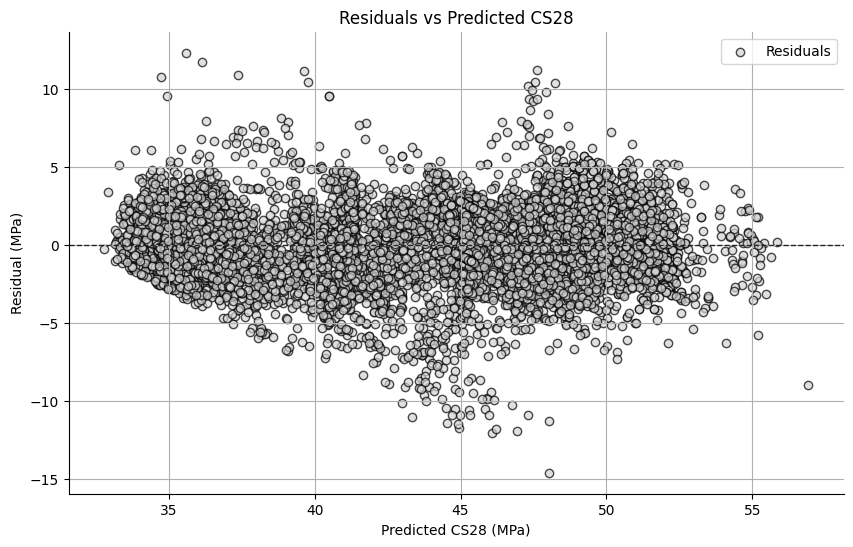

<IPython.core.display.Javascript object>

In [57]:
# Calculate residuals
test_data["RESIDUAL"] = test_data["CS28"] - test_data["CS28_PRED"]

plt.figure(figsize=(10, 6))

# Plot residuals vs predicted values
plt.scatter(
    test_data["CS28_PRED"],
    test_data["RESIDUAL"],
    color="lightgray",
    alpha=0.7,
    edgecolor="black",
    label="Residuals"
)

# Add horizontal line at zero for reference
plt.axhline(y=0, color="black", linestyle="--", linewidth=1, alpha=0.8)

plt.xlabel("Predicted CS28 (MPa)")
plt.ylabel("Residual (MPa)")
plt.title("Residuals vs Predicted CS28")
plt.legend()
plt.grid(True)

# Remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Save the figure
plt.savefig(
    "ecics_global_cm_p_btiss_top_one_pre_train_residuals_vs_predicted.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


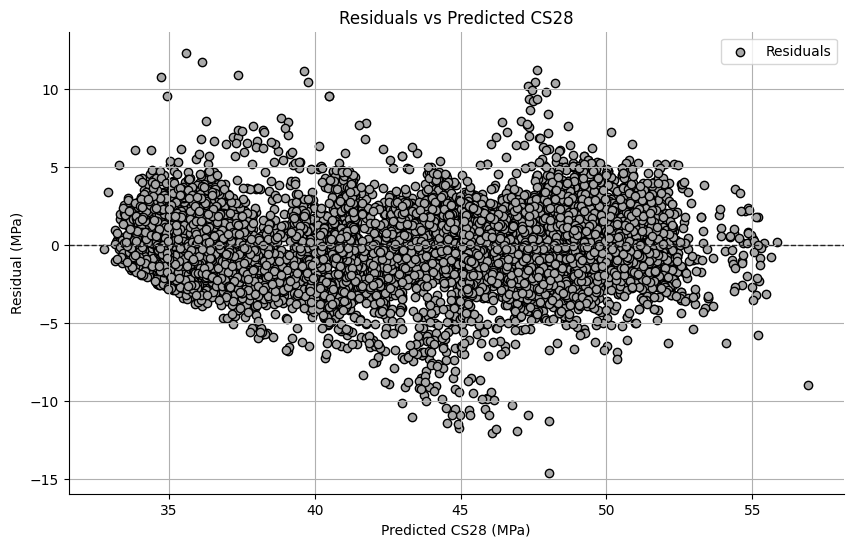

<IPython.core.display.Javascript object>

In [58]:
plt.figure(figsize=(10, 6))

# Plot residuals vs predicted values
plt.scatter(
    test_data["CS28_PRED"],
    test_data["RESIDUAL"],
    color="darkgray",
    alpha=1,
    edgecolor="black",
    label="Residuals",
)

# Add horizontal line at zero for reference
plt.axhline(y=0, color="black", linestyle="--", linewidth=1, alpha=0.8)

plt.xlabel("Predicted CS28 (MPa)")
plt.ylabel("Residual (MPa)")
plt.title("Residuals vs Predicted CS28")
plt.legend()
plt.grid(True)

# Remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Save the figure
plt.savefig(
    "ecics_global_cm_p_btiss_top_one_pre_train_residuals_vs_predicted.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()

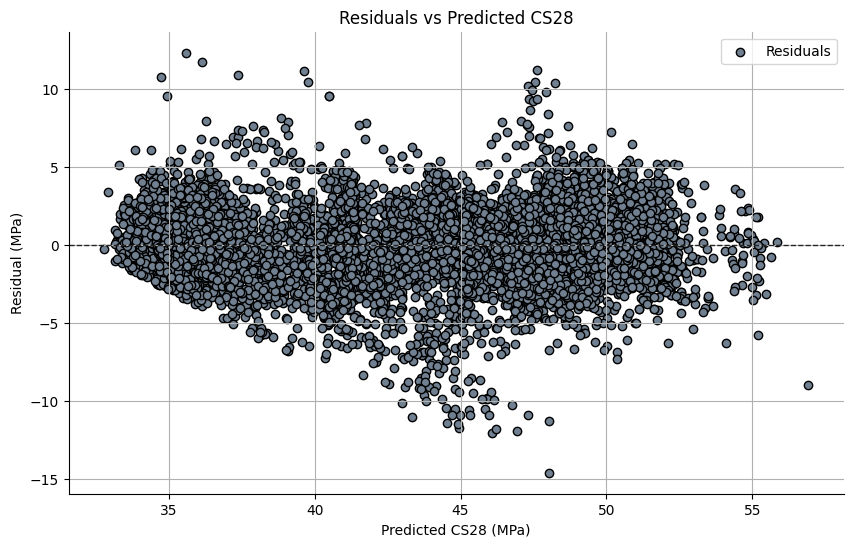

<IPython.core.display.Javascript object>

In [59]:
plt.figure(figsize=(10, 6))

# Plot residuals vs predicted values
plt.scatter(
    test_data["CS28_PRED"],
    test_data["RESIDUAL"],
    color="slategray",
    alpha=1,
    edgecolor="black",
    label="Residuals",
)

# Add horizontal line at zero for reference
plt.axhline(y=0, color="black", linestyle="--", linewidth=1, alpha=0.8)

plt.xlabel("Predicted CS28 (MPa)")
plt.ylabel("Residual (MPa)")
plt.title("Residuals vs Predicted CS28")
plt.legend()
plt.grid(True)

# Remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Save the figure
plt.savefig(
    "ecics_global_cm_p_btiss_top_one_pre_train_residuals_vs_predicted.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()

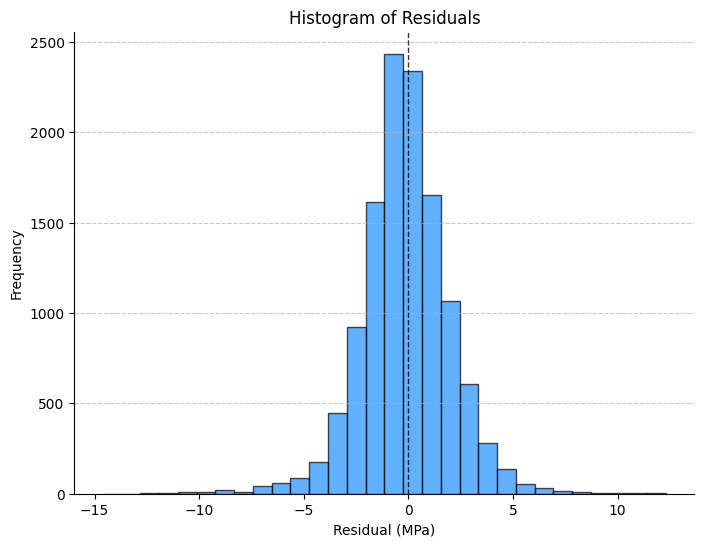

<IPython.core.display.Javascript object>

In [60]:
plt.figure(figsize=(8, 6))

# Plot histogram of residuals
plt.hist(
    test_data["RESIDUAL"],
    bins=30,  # Number of bins for better granularity
    color="dodgerblue",
    edgecolor="black",
    alpha=0.7
)

# Add labels and title
plt.xlabel("Residual (MPa)")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")

# Add a vertical line at 0 for reference
plt.axvline(x=0, color="black", linestyle="--", linewidth=1, alpha=0.8)

# Grid for readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Remove top and right spines for cleaner aesthetics
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Save the plot
plt.savefig(
    "ecics_global_cm_p_btiss_dominant_top_one_pre_train_residual_histogram.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()


In [61]:
def permutation_importance_distribution(model, X, y, metric, n_repeats=10):
    """
    Computes permutation importance for sequence models with 3D input,
    returning the distribution of importance scores across repetitions.
    """
    baseline_score = metric(y, model.predict(X))  # Compute baseline metric
    num_features = X.shape[1]  # Number of features
    importances = np.zeros(
        (num_features, n_repeats)
    )  # Store all scores for distribution
    set_seeds()  # Ensure reproducibility if necessary

    for i in range(num_features):
        for repeat in range(n_repeats):
            X_permuted = X.copy()
            # Shuffle feature i across all samples
            feature_values = X_permuted[:, i]
            np.random.shuffle(feature_values)
            X_permuted[:, i] = feature_values

            # Compute metric with permuted data
            permuted_score = metric(y, model.predict(X_permuted))
            # Store the importance score for this repetition
            importances[i, repeat] = baseline_score - permuted_score

    return importances

<IPython.core.display.Javascript object>

In [62]:
# Compute permutation importance
feature_importances = []
# importances = permutation_importance_seq(model, x_test, y_test, r2_score, n_repeats=10)
importances = permutation_importance_distribution(
    model, x_test, y_test, r2_score, n_repeats=10
)
feature_importances.append(importances)
# feature_importances = feature_importances[0].T
feature_importances = importances.T

<IPython.core.display.Javascript object>

In [63]:
import numpy as np
import pandas as pd
import seaborn as sns

# Average importances across folds
# mean_importances = np.mean(feature_importances.T, axis=0)

# importances_df = pd.DataFrame(feature_importances, columns=x.columns)
# Transpose the list of arrays so that each row corresponds to a permutation/model, and each column to a feature
importances_df = pd.DataFrame(feature_importances)

# Assign the feature names to the columns
importances_df.columns = x.columns

# Map importances to feature names
importances_df_mean = (
    importances_df.mean(axis=0)
    .to_frame()
    .reset_index(0)
    .rename({"index": "Feature", 0: "Importance"}, axis=1)
)

<IPython.core.display.Javascript object>

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_d

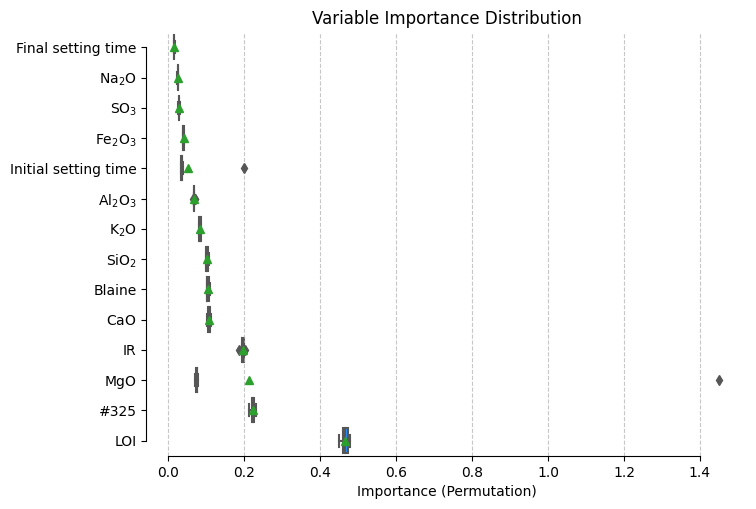

<IPython.core.display.Javascript object>

In [64]:
import matplotlib

perm_importances_df = importances_df


# Calculate the mean importance for each feature
mean_importances = perm_importances_df.mean().sort_values()

# Reorder the DataFrame columns based on mean importance
perm_importances_df = perm_importances_df[mean_importances.index]


# Backup the original backend
original_backend = plt.get_backend()

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)

# Convert chemical formulas using MathText syntax
perm_importances_df_plot = perm_importances_df.rename(
    columns={
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
        "Loss on Ignition": "LOI",
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df_plot,
    orient="h",
    color="dodgerblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (Permutation)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_global_cm_p_btiss_pre_train_transformer_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

plt.show()

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_d

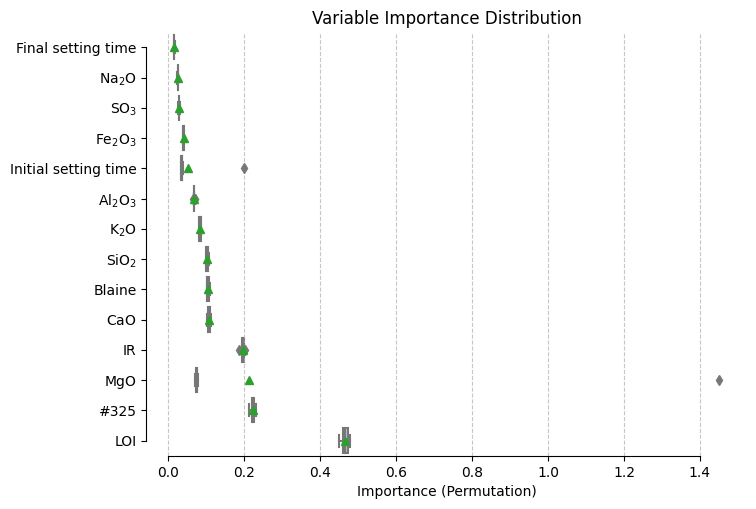

<IPython.core.display.Javascript object>

In [65]:
perm_importances_df = importances_df


# Calculate the mean importance for each feature
mean_importances = perm_importances_df.mean().sort_values()

# Reorder the DataFrame columns based on mean importance
perm_importances_df = perm_importances_df[mean_importances.index]


# Backup the original backend
original_backend = plt.get_backend()

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)

# Convert chemical formulas using MathText syntax
perm_importances_df_plot = perm_importances_df.rename(
    columns={
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
        "Loss on Ignition": "LOI",
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (Permutation)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_global_cm_p_btiss_pre_train_transformer_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

plt.show()

In [66]:
perm_importances_df_plot

,Final setting time,$\mathrm{Na_2O}$,$\mathrm{SO_3}$,$\mathrm{Fe_2O_3}$,Initial setting time,$\mathrm{Al_2O_3}$,$\mathrm{K_2O}$,$\mathrm{SiO_2}$,Blaine,$\mathrm{CaO}$,IR,$\mathrm{MgO}$,#325,LOI
0,0.014591,0.024547,0.026454,0.041634,0.035454,0.068232,0.086566,0.099332,0.102238,0.110784,0.196060,0.078870,0.219200,0.465929
1,0.015615,0.026098,0.028073,0.039264,0.034724,0.064901,0.081323,0.102844,0.106455,0.105195,0.194187,0.074136,0.228283,0.461894
2,0.013962,0.023642,0.029305,0.038754,0.037147,0.068524,0.082371,0.103275,0.102170,0.108460,0.194734,0.070062,0.214673,0.450281
3,0.015327,0.024856,0.025995,0.038279,0.032919,0.066885,0.081759,0.097835,0.101624,0.107107,0.199076,0.071706,0.223598,0.471475
4,0.014521,0.025453,0.028899,0.037867,0.037597,0.068321,0.086715,0.107965,0.101196,0.109144,0.197872,0.069362,0.223702,0.472125
5,0.015624,0.024690,0.027965,0.042063,0.034920,0.068154,0.084730,0.098487,0.104888,0.108131,0.197785,0.076500,0.224379,0.466028
6,0.015906,0.024298,0.030104,0.040839,0.199006,0.068082,0.085180,0.101988,0.106995,0.102374,0.185726,0.075117,0.220586,0.459710
7,0.015331,0.025690,0.026418,0.038250,0.035226,0.069518,0.085849,0.104223,0.108590,0.104370,0.202873,0.075547,0.222455,0.479592
8,0.014114,0.023483,0.027867,0.040323,0.033835,0.070421,0.080309,0.100243,0.102632,0.103806,0.194841,0.072549,0.213431,0.477725
9,0.016416,0.024944,0.028585,0.039528,0.034014,0.067968,0.081427,0.100997,0.101850,0.111075,0.195263,1.450913,0.229985,0.450487


<IPython.core.display.Javascript object>

In [67]:
perm_importances_df_plot.describe().T

,count,mean,std,min,25%,50%,75%,max
Final setting time,10.0,0.015141,0.000808,0.013962,0.014538,0.015329,0.015622,0.016416
$\mathrm{Na_2O}$,10.0,0.024770,0.000838,0.023483,0.024360,0.024773,0.025326,0.026098
$\mathrm{SO_3}$,10.0,0.027966,0.001342,0.025995,0.026807,0.028019,0.028820,0.030104
$\mathrm{Fe_2O_3}$,10.0,0.039680,0.001476,0.037867,0.038398,0.039396,0.040710,0.042063
Initial setting time,10.0,0.051484,0.051854,0.032919,0.034191,0.035073,0.036724,0.199006
$\mathrm{Al_2O_3}$,10.0,0.068101,0.001467,0.064901,0.067996,0.068193,0.068473,0.070421
$\mathrm{K_2O}$,10.0,0.083623,0.002426,0.080309,0.081510,0.083551,0.085682,0.086715
$\mathrm{SiO_2}$,10.0,0.101719,0.003036,0.097835,0.099560,0.101493,0.103167,0.107965
Blaine,10.0,0.103864,0.002648,0.101196,0.101930,0.102435,0.106063,0.108590
$\mathrm{CaO}$,10.0,0.107045,0.002994,0.102374,0.104577,0.107619,0.108973,0.111075


<IPython.core.display.Javascript object>